## Example usage of the gridcell package

In [1]:
%matplotlib inline

### Importing from files

We will use recorded data stored in the file ``../data/FlekkenBen.mat``. The format of this file happens to be compatible with the ``multiple_sessions`` function from the ``formats`` package. We know the physical units of the experimental environment, and using the ``range_`` parameter in ``multiple_sessions``, this allows the function to scale, translate and rotate the raw data to fit nicely inside environment.

The functions in the ``formats`` module can import data from several formats and return a standardized representation, described in the documentation for these functions.

In [2]:
from gridcell.formats import multiple_sessions

# Set range for the experimental environment
range_ = ((-75.0, 75.0), (-75.0, 75.0))
margin_range = ((-74.5, 74.5), (-74.5, 74.5))

flekkendata = multiple_sessions('../data/FlekkenBen.mat', range_=margin_range, rotate=True, translate=True)

Perhaps we happen to know that a particular cell is not a grid cell, and would like to exclude it from our analysis. This can be done as follows:

In [3]:
# This is not a grid cell!
del flekkendata[24]['spike_ts'][146]

Explanation: ``flekkendata[24]`` contains the data from the recording session with index 24 (the 25th recording session in the dataset, although we have no idea whether this numbering is chronological -- ``FlekkenBen.mat`` does not contain this information). The recording session is represented by a dict containing fields with the position of the rat over time, as well as the field ``'spike_ts'``, which is itself a dict containing the spike trains from cells recorded in this session. The spike trains are labeled by a key that identifies the cell. Ideally the key would contain info on e.g. tetrode and cluster number, but since this info was not provided in ``FlekkenBen.mat``, the keys here are just integers, and the cell we want to get rid of happens to have index ``146``. The statement above removes this spike train from the dataset.

### Setting up the CellCollection

The representation of the data provided by ``flekkendata`` is just a temporary interface. The functionality of the package is provided mainly through a class ``Cell`` representing the cells, and a container class ``CellCollection`` representing several cells. The standardized dataset representation can be used to initialize an instance of ``CellCollection``, creating ``Cell`` instances for each cell in the process. In order to do this, an peak threshold must be provided for each cell in order to facilitate peak detection in the firing rate autocorrelograms. This can be done using a ``defaultdict``, such that a standard value can be set, and only cells requiring a different threshold than this need to be explicitly treated. In any case, the ``thresholds`` parameter should be a nested mapping such that ``thresholds[key1][key2]`` gives the threshold for the cell with spike train ``flekkendata[key1]['spike_ts'][key2]``.

Note that the process of finding these thresholds is necessarily manual and iterative -- one must create the instances, look at the autocorrelograms, adjust the threshold, and repeat. No reliable way to automate this process has been found. However, this is an example of a workflow where the IPython Notebook really shines.

In [4]:
from gridcell.cells import CellCollection
from collections import defaultdict

# Default correlogram threshold: 0.20
default_threshold = 0.20
thresholds = [defaultdict(lambda: default_threshold) for __ in flekkendata]

# Some cells require special treatment
thresholds[1][8] = 0.34
thresholds[2][13] = 0.36
thresholds[3][16] = 0.42  # Or 0.32
thresholds[5][28] = 0.40
thresholds[5][29] = 0.34
thresholds[6][38] = 0.24
thresholds[6][39] = 0.35
thresholds[6][41] = 0.32
thresholds[7][43] = 0.15
thresholds[10][59] = 0.49  # Or 0.20
thresholds[11][63] = 0.35
thresholds[13][72] = 0.28  # Or 0.20
thresholds[15][82] = 0.17
thresholds[15][86] = 0.24
thresholds[16][89] = 0.39  # Or 0.34
thresholds[17][94] = 0.30  # Or 0.42
thresholds[18][104] = 0.46
thresholds[18][105] = 0.42
thresholds[19][117] = 0.30  # Or 0.20
thresholds[19][118] = 0.50  # Or 0.22
thresholds[19][119] = 0.32
thresholds[19][120] = 0.21  # Or 0.20
thresholds[19][123] = 0.37
thresholds[19][124] = 0.23
thresholds[20][128] = 0.26  # Or 0.37
#thresholds[23][140] = 0.23
thresholds[24][144] = 0.21
thresholds[24][145] = 0.21
thresholds[24][146] = 0.39
thresholds[25][150] = 0.12
thresholds[25][151] = 0.33  # Or 0.50
thresholds[25][152] = 0.21
thresholds[25][154] = 0.38  # Or 0.45
thresholds[27][159] = 0.19
thresholds[27][160] = 0.29
thresholds[27][161] = 0.33
thresholds[28][168] = 0.56
thresholds[28][169] = 0.40

# Instantiate CellCollection
cells = CellCollection.from_multiple_sessions(flekkendata, (42, 42), range_,
                                              thresholds, speed_window=1.0,
                                              min_speed=2.0, filter_size=3.3)

Note that the ``CellCollection.from_multiple_sessions`` constructor takes a number of keyword arguments affecting different aspects of the analysis, many of which are passed through to the ``Cell`` constructor. See the documentation for details

### Plotting and iterating the parameters

In [5]:
# To improve on the matplotlib aesthetics, we import the seaborn
# library and choose some nice colormaps
import seaborn
seaborn.set(rc={'figure.facecolor': '.98', 'legend.frameon': True})
ratecmap = 'YlGnBu_r'
corrcmap = 'RdBu_r'

Now, lets take a look at what we just created. The ``CellCollection`` instance can be accessed as a dict, and the keys are created from the session and cell keys explained earlier. The cell with spike train ``flekkendata[23]['spike_ts'][140]`` and threshold ``threshold[23][140]`` is now found at ``cells['23-140']``.

In [6]:
# Select a cell to have a closer look at
cell = cells['23-140']

Let's begin by plotting the raw data -- the path of the rat, with the spike locations of this cell superimposed.

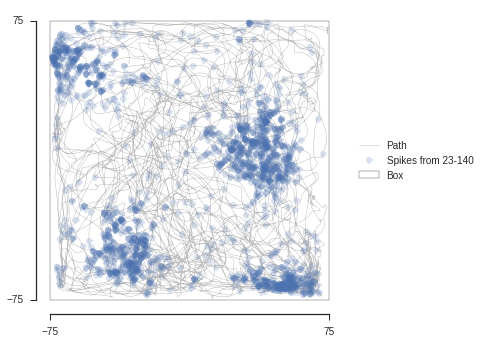

In [7]:
# Create a square patch representing the experimental environment
from matplotlib import patches
xmin, xmax = range_[0]
ymin, ymax = range_[1]
dx, dy = xmax - xmin, ymax - ymin
box = patches.Rectangle((xmin, ymin), dx, dy,
                        fill=False, label="Box")

# Plot the path and spikes
with seaborn.axes_style('ticks'):
    path = cell.pos.plot_path(label='Path')[0]
    axes = path.get_axes()
    cell.plot_spikes(axes=axes, alpha=0.2, label='Spikes from 23-140')
    axes.add_patch(box)
    axes.set(xlim=[xmin - 0.05 * dx, xmax + 0.55 * dx],
             ylim=[ymin - 0.05 * dy, ymax + 0.05 * dy],
             xticks=[xmin, xmax], yticks=[xmin, xmax])
    axes.legend(loc=5)
    seaborn.despine(offset=0, trim=True)

That looks promising. Let's plot the firing rate map. This map has been passed through a smoothing filter with filter size given by the parameter ``filter_size`` in the ``CellCollection`` constructor.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f871e2284a8>,
 <matplotlib.colorbar.Colorbar at 0x7f8706430320>)

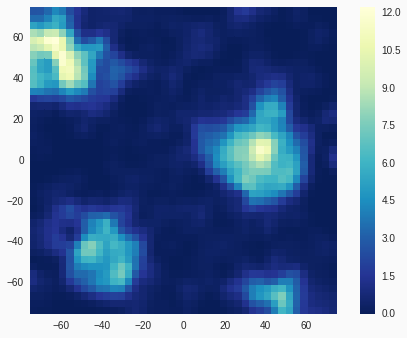

In [8]:
cell.plot_firing_rate(cmap=ratecmap)

This definitely looks like a grid cell, with a pretty large grid spacing. Let's see how the autocorrelogram looks.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f872417e198>,
 <matplotlib.colorbar.Colorbar at 0x7f8706319cc0>)

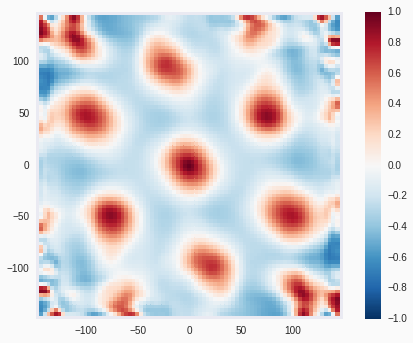

In [9]:
cell.plot_autocorrelogram(cmap=corrcmap)

Pretty nice, actually. But how does the default threshold work with that noise near the edge?

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8706328630>,
 <matplotlib.colorbar.Colorbar at 0x7f87062c50f0>)

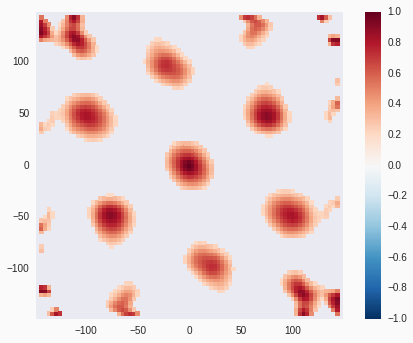

In [10]:
cell.plot_autocorrelogram(cmap=corrcmap, threshold=True)

Not very nice. Let's investigate what the threshold for this cell should be, assuming as a rule that the threshold should be as close as possible to the default value (0.20), while allowing all the six inner peaks to be identified and separated from each other and background noise. In order to plot the autocorrelgram with a custom threshold, we abandon the ``plot_autocorrelgram`` method of the ``Cell`` instance for the moment, and use the ``plot`` method of the ``IntensityMap2D`` instance returned from the ``autocorrelate`` method of ``Cell`` instead.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f87063007b8>,
 <matplotlib.colorbar.Colorbar at 0x7f87061fd2e8>)

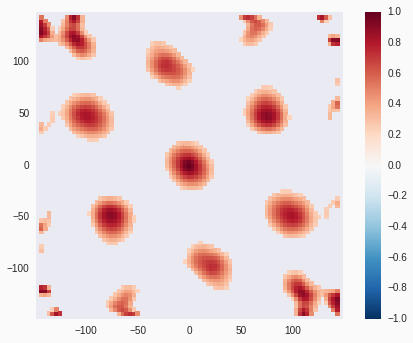

In [11]:
cell.autocorrelate().plot(cmap=corrcmap, vmin=-1.0, vmax=1.0, threshold=0.23)

That's it! We only needed to increase the threshold by 0.03. Now, let's update ``thresholds`` and reinstantiate the ``CellCollection`` instance.

In [12]:
thresholds[23][140] = 0.23
cells = CellCollection.from_multiple_sessions(flekkendata, (42, 42), range_,
                                              thresholds, speed_window=1.0,
                                              min_speed=2.0, filter_size=3.3)

We should check that the problem has been fixed:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8707da9ef0>,
 <matplotlib.colorbar.Colorbar at 0x7f8706143b00>)

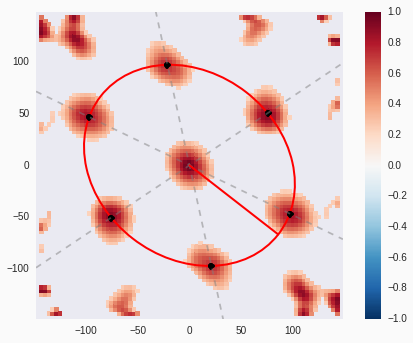

In [13]:
cell = cells['23-140']
cell.plot_autocorrelogram(cmap=corrcmap, threshold=True, peaks=True, ellipse=True)

Notice how the detected peak centers, and the ellipse fitted through them, were added using the keywords ``peaks`` and ``ellipse``. These keywords are provided for convenience, and uses default parameters for the appearance of the peaks and ellipse. For more fine grained control, use the ``plot_peaks`` and ``plot_ellipse`` methods instead. 

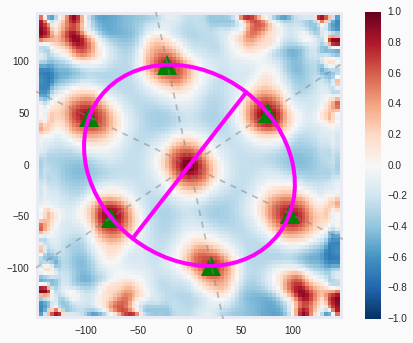

In [14]:
cell.plot_autocorrelogram(cmap=corrcmap, threshold=False)
cell.plot_peaks(marker='^', color='green', markersize=20)
cell.plot_ellipse(smajaxis=False, minaxis=True, color='magenta', linewidth=4, zorder=3)

### Clustering and modules

The next step is to try to cluster the cells into modules. There are several clustering algorithms available for this purpose. Here, we use the K-means algorithm, implemented using the ``k_means`` function from ``scikit-learn``. We anticipate 4 modules.

In [15]:
modules, outliers = cells.k_means(n_clusters=4)

All clustering methods have a common return signature: ``modules, outliers``. The variable ``modules`` is a list containing a ``Module`` instance for each of the detected modules. ``Module`` is a subclass of ``CellCollection``, implementing some extra module-specific functionality for analyzing the phases of the cells in the module. The variable ``outliers`` is a CellCollection instance containing the cells that were not assigned to any module. When using the K-means algorithm, all cells are assigned to a module, so ``outliers`` is empty.

Let's take a look at the clustering by plotting the scales, orientation angles and ellipse parameters of the cells in each module next to each other.

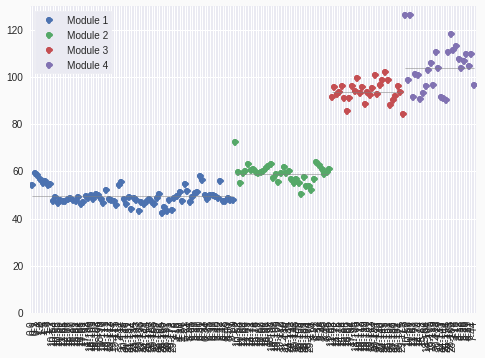

In [16]:
for (i, mod) in enumerate(modules):
    line = mod.plot_scales(label="Module {}".format(i + 1))[0]
axes = line.get_axes()
axes.set_ylim(bottom=0.0)
axes.legend(loc=0)

The x axis labels are supposed to be the cell keys (e.g. 18-98), but the number of cells in this dataset renders them unreadable. They can of course be removed if desired.

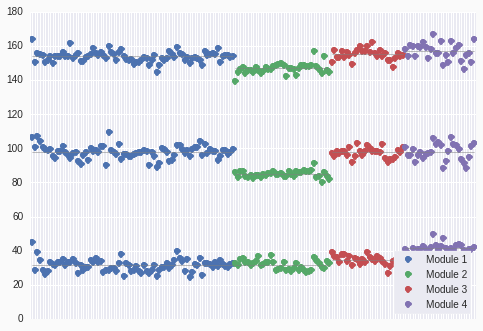

In [17]:
for (i, mod) in enumerate(modules):
    line = mod.plot_angles(label="Module {}".format(i + 1))[0]
axes = line.get_axes()
axes.set_xticklabels('')
axes.set_ylim(bottom=0.0, top=180.0)
axes.legend(loc=0)

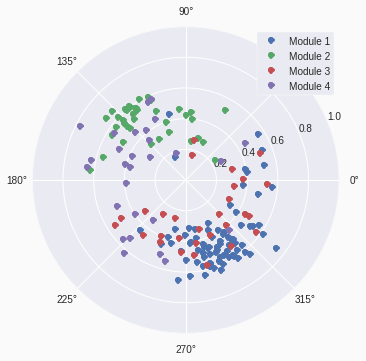

In [18]:
for (i, mod) in enumerate(modules):
    line = mod.plot_ellpars(label="Module {}".format(i + 1))[0]
axes = line.get_axes()
axes.legend(loc=0)

This walkthrough has demonstrated only some of the capabilities of the gridcell package. To find out more, read the docstrings in the code.